In [20]:
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import os
import numpy as np

# Carregar modelo CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Lista de pastas para suas imagens
paths = ['airfield', 'bus', 'cafeteria', 'castle', 'highway']
embs = []

for path in paths:
    image_paths = os.listdir(path)
    embeddings = []

    for img_path in image_paths:
        image = Image.open(os.path.join(path, img_path))
        inputs = processor(images=image, return_tensors="pt")
        outputs = model.get_image_features(**inputs)
        embeddings.append(outputs.detach().cpu().numpy())

    embeddings = np.vstack(embeddings)
    embedding_medio = np.mean(embeddings, axis=0)

    norm = np.linalg.norm(embedding_medio)
    embedding_normalizado = embedding_medio / norm

    # Salva em arquivo diferente para cada categoria
    filename = f"embedding_medio_normalizado_{path}.txt"
    with open(filename, "w") as f:
        f.write(", ".join(map(str, embedding_normalizado)))

    print(f"Embedding médio normalizado salvo em '{filename}'")
    embs.append(embedding_normalizado)


Embedding médio normalizado salvo em 'embedding_medio_normalizado_airfield.txt'
Embedding médio normalizado salvo em 'embedding_medio_normalizado_bus.txt'
Embedding médio normalizado salvo em 'embedding_medio_normalizado_cafeteria.txt'
Embedding médio normalizado salvo em 'embedding_medio_normalizado_castle.txt'
Embedding médio normalizado salvo em 'embedding_medio_normalizado_highway.txt'


In [34]:
image_paths = ["image1.jpg", "image2.jpg"]

embeddings = []
embs2 = []

for img_path in image_paths:
    image = Image.open(img_path)
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    embeddings.append(outputs.detach().cpu().numpy())


for i, emb in enumerate(embeddings):
    norm = np.linalg.norm(emb)
    embedding_normalizado = emb / norm
    embs2.append(embedding_normalizado)

In [37]:
len(embs), len(embs2)

(5, 2)

AttributeError: 'list' object has no attribute 'shape'

In [52]:
embs2 = [v.squeeze() for v in embs2]  # agora cada vetor é 1D (512,)


In [53]:
from sklearn.metrics.pairwise import cosine_similarity

# embs e embs2 são arrays numpy de formato (n_samples_1, dim) e (n_samples_2, dim)
similarity_matrix = cosine_similarity(embs, embs2)

print(similarity_matrix)  # Matriz de tamanho (n_samples_1, n_samples_2)


[[0.6013254  0.4319015 ]
 [0.6763138  0.51939744]
 [0.61813474 0.6564508 ]
 [0.54627985 0.48749232]
 [0.8154751  0.58003324]]


In [55]:
import numpy as np

def softmax(x, axis=1):
    x_exp = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return x_exp / np.sum(x_exp, axis=axis, keepdims=True)

softmax_similarities = softmax(similarity_matrix, axis=0)

print(softmax_similarities)


[[0.18939131 0.17985524]
 [0.20413953 0.19630083]
 [0.19260177 0.22513533]
 [0.1792479  0.19013667]
 [0.2346195  0.20857194]]


In [60]:
categories = ["airfield", "bus interior", "cafeteria", "castle", "highway"]


similarity_dict = {cat: vec for cat, vec in zip(categories, softmax_similarities)}

# Exibir
for k, v in similarity_dict.items():
    print(f"{k}: {round(v[1] * 100, 2)}%")

airfield: 17.99%
bus interior: 19.63%
cafeteria: 22.51%
castle: 19.01%
highway: 20.86%


In [62]:
import numpy as np

# Vetores
v1 = np.array([0.6, 0.8])
v2 = np.array([0.9, 0.7])
v3 = np.array([0.2, 0.1])

# Função similaridade de cosseno
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Calculando similaridades
sim_v1_v2 = cosine_similarity(v1, v2)
sim_v1_v3 = cosine_similarity(v1, v3)

# Função Softmax
def softmax(x):
    e_x = np.exp(x - np.max(x))  # estabilidade numérica
    return e_x / e_x.sum()

# Softmax entre as similaridades
similarities = np.array([sim_v1_v2, sim_v1_v3])
softmax_similarities = softmax(similarities)

print(f"Similaridade cosseno entre v1 e v2: {sim_v1_v2:.4f}")
print(f"Similaridade cosseno entre v1 e v3: {sim_v1_v3:.4f}")
print(f"Softmax das similaridades: {softmax_similarities}")


Similaridade cosseno entre v1 e v2: 0.9648
Similaridade cosseno entre v1 e v3: 0.8944
Softmax das similaridades: [0.51757691 0.48242309]


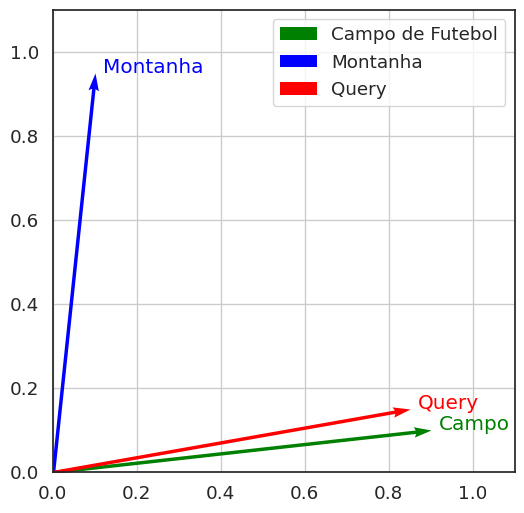

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Vetores simulados (embeddings de imagens)
campo_futebol = np.array([0.9, 0.1])
montanha = np.array([0.1, 0.95])
query = np.array([0.85, 0.15])

# Criando o gráfico com setas (vetores)
plt.figure(figsize=(8, 6))

# Plotando os vetores do suporte e da query
plt.quiver(0, 0, campo_futebol[0], campo_futebol[1], angles='xy', scale_units='xy', scale=1, color='green', label='Campo de Futebol')
plt.quiver(0, 0, montanha[0], montanha[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Montanha')
plt.quiver(0, 0, query[0], query[1], angles='xy', scale_units='xy', scale=1, color='red', label='Query')

# Anotações de texto
plt.text(campo_futebol[0]+0.02, campo_futebol[1], 'Campo', color='green')
plt.text(montanha[0]+0.02, montanha[1], 'Montanha', color='blue')
plt.text(query[0]+0.02, query[1], 'Query', color='red')

# Ajustes do gráfico
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


Campo de Futebol Normalizado: [0.994 0.11 ]
Montanha Normalizado: [0.301 0.954]
Query Normalizado: [0.973 0.229]


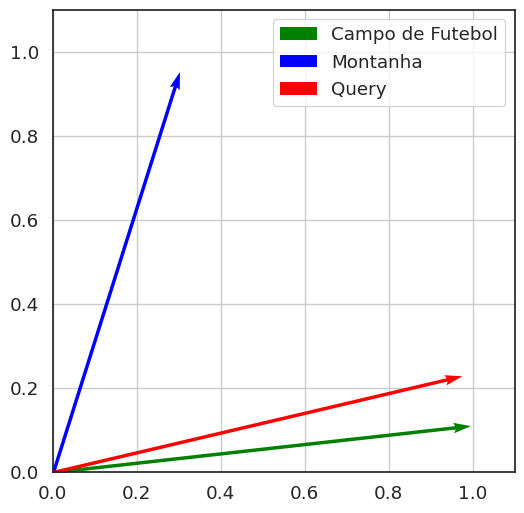

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Vetores originais (embeddings)
campo_futebol = np.array([0.9, 0.1])
montanha = np.array([0.3, 0.95])
query = np.array([0.85, 0.2])

# Função para normalizar um vetor
def normalize(v):
    return v / np.linalg.norm(v)

# Normalizando os vetores
campo_futebol_norm = normalize(campo_futebol)
montanha_norm = normalize(montanha)
query_norm = normalize(query)

print("Campo de Futebol Normalizado:", np.round(campo_futebol_norm, 3))
print("Montanha Normalizado:", np.round(montanha_norm, 3))
print("Query Normalizado:", np.round(query_norm, 3))

# Criando o gráfico com setas (vetores normalizados)
plt.figure(figsize=(8, 6))

plt.quiver(0, 0, campo_futebol_norm[0], campo_futebol_norm[1], angles='xy', scale_units='xy', scale=1, color='green', label='Campo de Futebol')
plt.quiver(0, 0, montanha_norm[0], montanha_norm[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Montanha')
plt.quiver(0, 0, query_norm[0], query_norm[1], angles='xy', scale_units='xy', scale=1, color='red', label='Query')

plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [24]:
# Produto interno entre vetores normalizados = similaridade de cosseno
sim_campo_query = campo_futebol_norm @ query_norm
sim_montanha_query = montanha_norm @ query_norm

print(f"Similaridade de Cosseno (Query x Campo de Futebol): {sim_campo_query:.2f}")
print(f"Similaridade de Cosseno (Query x Montanha): {sim_montanha_query:.2f}")


Similaridade de Cosseno (Query x Campo de Futebol): 0.99
Similaridade de Cosseno (Query x Montanha): 0.51
